In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
tfd = tf.distributions
plt.style.use('ggplot')
%matplotlib inline

AttributeError: module 'tensorflow' has no attribute 'distributions'

In [3]:
a = 0.001

host_size = 1000
host_sequence = np.zeros(host_size)

antibody_size = 20
sample_size = 100

p = np.cos(np.array(range(host_size))/(host_size/20))
p = (p+1.)/2.
p[:10]

array([1.        , 0.9999    , 0.99960005, 0.99910027, 0.99840085,
       0.99750208, 0.99640432, 0.995108  , 0.99361364, 0.99192185])

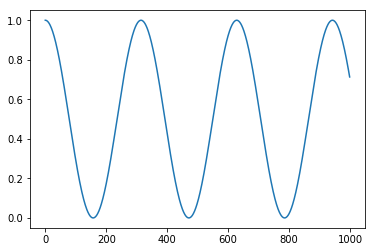

In [4]:
plt.plot(p)

In [5]:
host_sequence = np.array(np.random.uniform(size=host_size) > p).astype(np.float32)

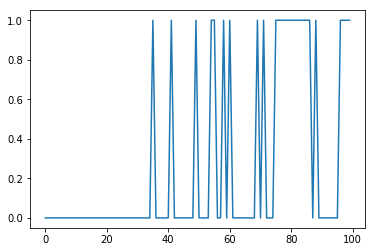

In [6]:
plt.plot(host_sequence[:100])

In [7]:
max(host_sequence)

1.0

"plt.savefig('song_lab_rotation/host_seq_auto.png')"

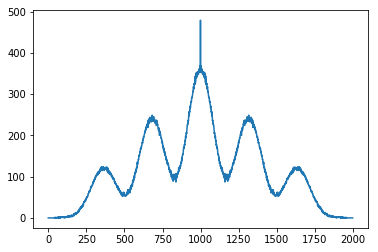

In [8]:
plt.plot(np.correlate(host_sequence, host_sequence, mode='full'))
'''plt.savefig('song_lab_rotation/host_seq_auto.png')'''

In [9]:
host_epitopes = np.array([host_sequence[i:i + antibody_size] for i in np.random.choice(range(host_size - antibody_size), size=sample_size)])

(-0.5, 19.5, 29.5, -0.5)

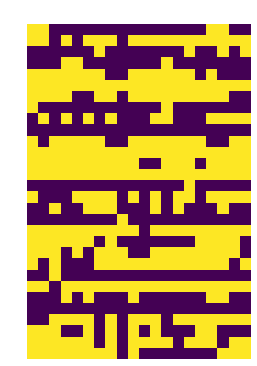

In [10]:
plt.matshow(host_epitopes[:30])
plt.axis('off')

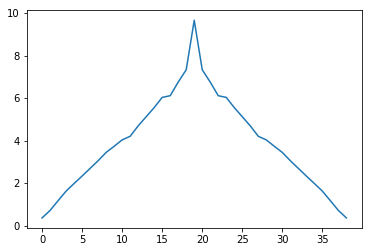

In [11]:
plt.plot(np.average(np.array([np.correlate(x, x, mode='full') for x in host_epitopes]), 0))

(-0.5, 19.5, 99.5, -0.5)

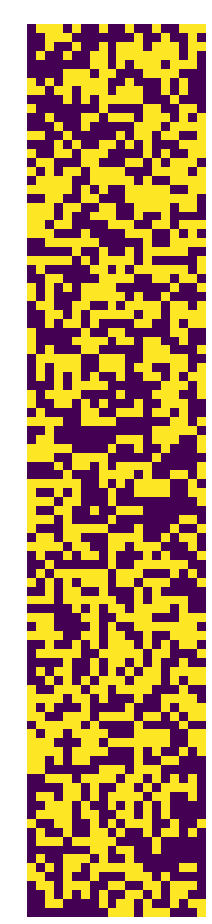

In [12]:
test = np.random.uniform(size=(sample_size, antibody_size)) > 0.5
plt.matshow(test)
plt.axis("off")

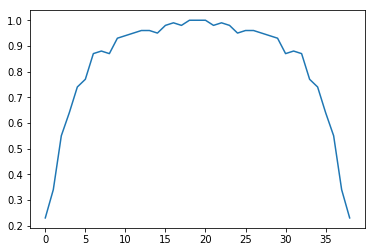

In [13]:
plt.plot(np.average(np.array([np.correlate(x, x, mode='full') for x in test]), 0))

In [14]:
tf.reset_default_graph()


def G(z, reuse=None):
    with tf.variable_scope('host_generator'):
        h = tf.layers.dense(z, 10, activation=tf.nn.relu)
        h = tf.layers.dense(h, 10, activation=tf.nn.relu)
        o = tf.layers.dense(h, antibody_size, activation=None)
        host_dist = tf.contrib.distributions.RelaxedBernoulli(0.1, logits=o)
    return host_dist.sample()

def Gf(z, reuse=None):
    with tf.variable_scope('foreign_generator'):
        h = tf.layers.dense(z, 10, activation=tf.nn.relu)
        h = tf.layers.dense(h, 10, activation=tf.nn.relu)
        o = tf.layers.dense(h, antibody_size, activation=None)
        f_dist = tf.contrib.distributions.RelaxedBernoulli(.1, logits=o)
    return f_dist.sample()

host_samples = G(tf.random_normal(shape=[100,2]))
hc = (host_samples-0.5)*2.
cov_loss = tf.matmul(hc, tf.transpose(hc))**2
cov_loss = tf.reduce_mean(cov_loss - tf.diag(tf.diag_part(cov_loss)))

foreign_samples = Gf(tf.random_normal(shape=[100,2]))

def cross_entropy(x, y):
    return -y*tf.log(x + 10**-8) - (1. - y)*tf.log(1. - x + 10**-8)

gloss = -1*tf.reduce_mean(tf.reduce_sum(cross_entropy(host_samples, host_epitopes), axis=1)) + 0.1*cov_loss
#gloss += tf.reduce_mean(tf.reduce_sum(cross_entropy(host_samples, foreign_samples), axis=1)) 
gfloss = -1*tf.reduce_mean(tf.reduce_sum(cross_entropy(foreign_samples, host_samples), axis=1)) 

update_gf_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='foreign_generator')
update_g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='host_generator')
update_g_step = tf.train.AdamOptimizer().minimize(gloss, var_list=update_g_vars)
update_gf_step = tf.train.AdamOptimizer().minimize(gfloss, var_list=update_gf_vars)
init = tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)) 
sess = tf.Session()
sess.run(init) 

(-0.5, 19.5, 29.5, -0.5)

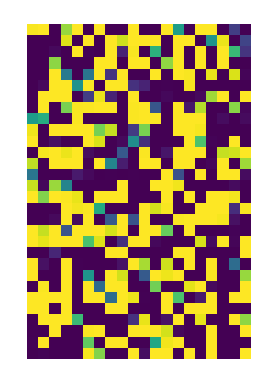

In [15]:
hb = sess.run(host_samples)[:30]
plt.matshow(hb)
plt.axis('off')


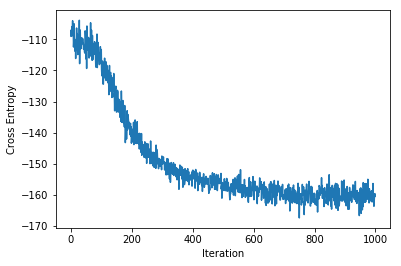

In [16]:
losses = []

for i in range(1000):
    sess.run([update_g_step])
    losses += [sess.run([gloss])]
    print(i, end='\r')
    
for l in np.array(losses).T:
    plt.figure()
    plt.plot(l)
    plt.xlabel('Iteration')
    plt.ylabel('Cross Entropy')
   

(-0.5, 19.5, 29.5, -0.5)

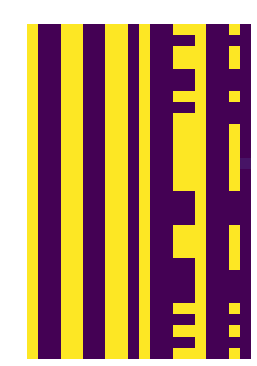

In [17]:

plt.matshow(sess.run(host_samples)[:30])
plt.axis('off')


In [18]:
tf.reset_default_graph()


def G(z, reuse=None):
    with tf.variable_scope('host_generator'):
        h = tf.layers.dense(z, 10, activation=tf.nn.relu)
        h = tf.layers.dense(h, 10, activation=tf.nn.relu)
        o = tf.layers.dense(h, antibody_size, activation=None)
        host_dist = tf.contrib.distributions.RelaxedBernoulli(0.1, logits=o)
    return host_dist.sample()

def Gf(z, reuse=None):
    with tf.variable_scope('foreign_generator'):
        h = tf.layers.dense(z, 10, activation=tf.nn.relu)
        h = tf.layers.dense(h, 10, activation=tf.nn.relu)
        o = tf.layers.dense(h, antibody_size, activation=None)
        f_dist = tf.contrib.distributions.RelaxedBernoulli(.1, logits=o)
    return f_dist.sample()

host_samples = G(tf.random_normal(shape=[100,10]))
hc = (host_samples-0.5)*2.

cov_loss = tf.matmul(hc, tf.transpose(hc))**2
cov_loss = tf.reduce_mean(cov_loss - tf.diag(tf.diag_part(cov_loss)))

foreign_samples = Gf(tf.random_normal(shape=[100,10]))
fc = (foreign_samples-0.5)*2.

def cross_entropy(x, y):
    return -y*tf.log(x + 10**-8) - (1. - y)*tf.log(1. - x + 10**-8)

gloss = -1*tf.reduce_mean(tf.reduce_sum(cross_entropy(host_samples, host_epitopes), axis=1)) + .1*cov_loss
gloss += tf.reduce_mean(tf.reduce_sum(cross_entropy(host_samples, foreign_samples), axis=1)) 

cov_loss = tf.matmul(fc, tf.transpose(fc))**2
cov_loss = tf.reduce_mean(cov_loss - tf.diag(tf.diag_part(cov_loss)))

gfloss = -1*tf.reduce_mean(tf.reduce_sum(cross_entropy(foreign_samples, host_samples), axis=1)) + .1*cov_loss
floss = tf.reduce_mean(tf.reduce_sum(cross_entropy(host_samples, foreign_samples), axis=1)) 

update_gf_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='foreign_generator')
update_g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='host_generator')
update_g_step = tf.train.AdamOptimizer().minimize(gloss, var_list=update_g_vars)
update_gf_step = tf.train.AdamOptimizer().minimize(gfloss, var_list=update_gf_vars)
init = tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)) 
sess = tf.Session()
sess.run(init) 

In [19]:
losses = []

for i in range(1000):
    sess.run([update_g_step])
    sess.run([update_gf_step])
    losses += [sess.run([gloss, gfloss, floss])]
    print(i, end='\r')

"plt.savefig('song_lab_rotation/ad_ff_loss.png')"

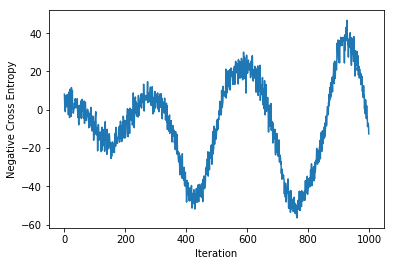

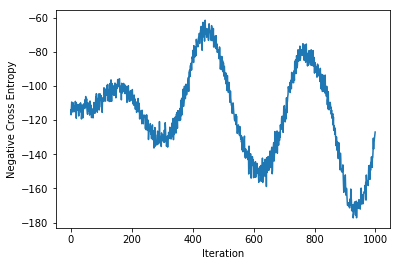

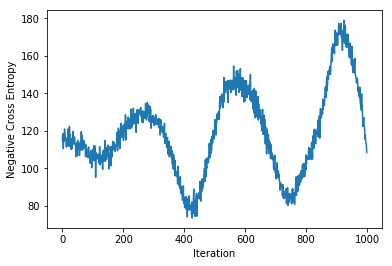

In [20]:
l1, l2, l3 = np.array(losses).T
plt.figure()
plt.plot(l1)
plt.xlabel('Iteration')
plt.ylabel('Negative Cross Entropy')
"plt.savefig('song_lab_rotation/ad_h_loss.png')"

plt.figure()
plt.plot(l2)
plt.xlabel('Iteration')
plt.ylabel('Negative Cross Entropy')
"plt.savefig('song_lab_rotation/ad_gf_loss.png')"

plt.figure()
plt.plot(l3)
plt.xlabel('Iteration')
plt.ylabel('Negative Cross Entropy')
"plt.savefig('song_lab_rotation/ad_ff_loss.png')"

"plt.savefig('song_lab_rotation/ad_host_end.png')"

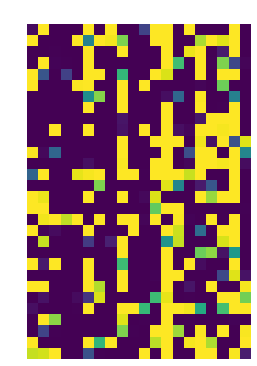

In [21]:

plt.matshow(sess.run(host_samples)[:30])
plt.axis('off')
"plt.savefig('song_lab_rotation/ad_host_end.png')"

"plt.savefig('song_lab_rotation/ad_f_end.png')"

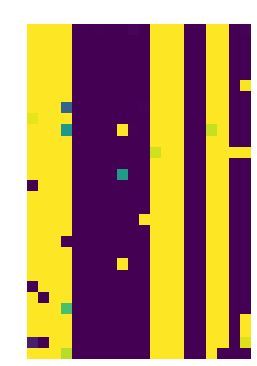

In [22]:
plt.matshow(sess.run(foreign_samples)[:30])
plt.axis('off')
"plt.savefig('song_lab_rotation/ad_f_end.png')"

In [23]:
host = [1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1]

In [24]:
anti = [0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0]

In [25]:
def bitMatches(host, anti):
    maxComplements = 0
    currentComplements = 0
    boolvalue = True
    for x in range(len(host)):
        if boolvalue == True:
            if host[x] != anti[x]:
                currentComplements += 1
                if currentComplements > maxComplements:
                    maxComplements = currentComplements
            else:
                currentComplements = 0

    return maxComplements

In [26]:
bitMatches(host, anti)

42

In [27]:
tcell = []
for x in range(42):
    tcell = np.append(tcell, np.random.randint(2))

In [28]:
tcell

array([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1.])

In [29]:
bitMatches(tcell, host)

5

In [30]:
bitMatches(anti, tcell)

5